In [0]:
import shutil
import os

cwd = os.getcwd()
#Path in drive to 

src = "/content/drive/My Drive/deep learning code/corona virus Transfer learning/xray_data.zip"
shutil.copy(src,cwd)

'/content/xray_data.zip'

In [0]:
import zipfile
pascal3category = zipfile.ZipFile('xray_data.zip', 'r')
pascal3category = pascal3category.extractall()

In [0]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 48kB/s 
     |████████████████████████████████| 3.2MB 37.7MB/s 
     |████████████████████████████████| 491kB 50.9MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [0]:
#plot-metric to display ROC curve
!pip install plot-metric

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1383140789670574799
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 221180622193813775
physical_device_desc: "device: XLA_CPU device"
]


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as Vgg16processInput
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as ResNet50_processInput
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as InceptionV3_processInput
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as Xception_processInput

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as Vgg19processInput
# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from keras import optimizers
from keras.layers import Dense,GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint ,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import auc
from plot_metric.functions import BinaryClassification
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
import sklearn
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Some usefull Functions to use for training

'''Dictionery to map model names'''
MODELS = {
	"vgg16": VGG16,
	"vgg19": VGG19,
	"inception": InceptionV3,
	"xception": Xception, # TensorFlow ONLY
	"resnet": ResNet50
}

#'''Function to generate data generator from directory'''
def get_generator(path_dir,processinput,img_size,batchsize,shuffle_status):

  datagen=ImageDataGenerator(preprocessing_function=processinput) #included in our dependencies
  generator1=datagen.flow_from_directory(path_dir,
                                         target_size=img_size,
                                         color_mode='rgb',
                                         batch_size=batchsize,
                                         class_mode='binary',
                                         shuffle=shuffle_status)
  return generator1

#'''This function will return a corresponding model with given model name'''
def get_pretrained_model(modelname,freeze):
  Network = MODELS[modelname]
  model = Network(weights="imagenet",include_top=False)
  if freeze:
    for layer in model.layers:
      layer.trainable = False
  return model

#'''This function will add new dense layers to the input model'''
def add_dense(input_model,numbers_list):
  x = input_model.output
  for i in range(len(numbers_list)-1):
    x = Dense(numbers_list[i], activation='relu')(x)
  output = Dense(numbers_list[-1], activation='sigmoid')(x)
  model = Model(inputs=input_model.inputs, outputs=output)
  return model


#This function will add Global average pooling layer to the input model
def add_GAP(input_model):
  x = input_model.output
  x=GlobalAveragePooling2D()(x)
  # define new model
  model = Model(inputs=input_model.inputs, outputs=x)
  return model

#This function will store callbacks
def mycallbacks(checkpoint_name):

  ModelCheckpointcheckpoint = ModelCheckpoint(checkpoint_name,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
  EarlyStoppingearlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3,verbose = 1,restore_best_weights = True)
  reducelr=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
  callbacks=[ModelCheckpointcheckpoint,EarlyStoppingearlystop,reducelr]
  return callbacks

#This function will display ROC curve 
def get_ROC(y_test,y_pred):
  bc = BinaryClassification(y_test, y_pred, labels=["covid19", "pneumonia"])
  # Figures
  plt.figure(figsize=(5,5))
  bc.plot_roc_curve()
  plt.show()


#this function will return 
def get_prediction(model,test_generator):
  preds = model.predict_generator(test_generator)
  return preds

def start_training(model,train_generator,val_generator,myepochs,callbacks):
  step_size_train=train_generator.n//train_generator.batch_size
  val_size=val_generator.n//val_generator.batch_size
  #Training
  history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=step_size_train,
                                epochs=myepochs,
                                validation_data=val_generator,
                                validation_steps=val_size,
                                callbacks=callbacks)
  return history

def extract_features(model,generator):

  #Extracting features of train,validation and test data
  data_y = generator.classes
  data_x = model.predict_generator(generator)
  return data_x,data_y

'''This function will return a neural network with dense layers'''
def get_neural_model(input_size,neurons_list):

  visible = Input(shape=(input_size,))
  for i in range(len(neurons_list)-1):
    x = Dense(10, activation='relu')(visible)
  output = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=visible, outputs=output)
  return model

def test(model,generator):
  loss,acc= model.evaluate_generator(generator)
  return loss,acc

# This function is plotting confusion matrix.
def draw_confusion_matrix(cm,test_y):
  df_cm = pd.DataFrame(cm, columns=np.unique(test_y), index = np.unique(test_y))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (6,3))
  sn.set(font_scale=1.4) #for label size
  sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})

#this function will plot accuracy and loss curve
def plot_curve(train,val,string1):
  plt.plot(train,'k--')
  plt.plot(val,'k--')
  plt.title('model '+string1)
  plt.ylabel(string1)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# **Vgg19**

In [0]:
#Some important variable initializers
batchsize = 8
img_size = (448,448)
myepochs = 100

numbers_list = [256,1]

#Building Vgg19 model
print("Building VGG19 model")
model1 = get_pretrained_model('vgg19',freeze = True)
model1 = add_GAP(model1)
model1 = add_dense(model1,numbers_list)

#Declaring neural network
checkpoint_name='vgg19.h5'
callback1 = mycallbacks(checkpoint_name)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
model1.summary()

#declaring generators
print("Declaring data generators..")
processinput = Vgg19processInput
train_gen = get_generator('/content/train',processinput,img_size,batchsize,True)
test_gen = get_generator('/content/test',processinput,img_size,batchsize,True)
val_gen = get_generator('/content/val',processinput,img_size,batchsize,True)

#training the model
hist = start_training(model1,train_gen,val_gen,myepochs,callback1)

Building VGG19 model
80142336/80134624 [==============================] - 2s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_______________________________________

In [0]:
model1.load_weights('vgg19.h5')

In [0]:
# Plotting Accuracy and Loss curve
plot_curve(hist.history['accuracy'],hist.history['val_accuracy'],'Accuracy')
plot_curve(hist.history['loss'],hist.history['val_loss'],'Loss')

In [0]:
#testing model
step_size_test=test_gen.n//test_gen.batch_size
loss,acc = model1.evaluate_generator(test_gen,step_size_test,verbose=0)
print("Testing Results => Acc: ",round(acc,2)*100,"Loss: ",round(loss,2))

#Plotting ROC curve
print("ROC Curve")
test_gen = get_generator('/content/test',processinput,img_size,batchsize,False)
test_y = test_gen.classes
y_pred = model1.predict_generator(test_gen)
get_ROC(test_y,y_pred)

# Report of Precision, Recall, F1_score
print ('Report : ')
print (classification_report(test_y, np.where(y_pred.flatten()>0.5,1,0) ))

#Confusion matrix
print("DIsplaying Confusion")
labels = [0,1]
cm = confusion_matrix(test_y, np.where(y_pred.flatten()>0.5,1,0), labels)
draw_confusion_matrix(cm,test_y)



# **Resnet50**

In [0]:
#Some important variable initializers
batchsize = 8
img_size = (448,448)
myepochs = 100

numbers_list = [1024,512,1]

#Building Xception model
print("Building Resnet50 model")
model1 = get_pretrained_model('resnet',freeze = False)
model1 = add_GAP(model1)
model1 = add_dense(model1,numbers_list)

#Declaring neural network
checkpoint_name='resnet.h5'
callback1 = mycallbacks(checkpoint_name)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
model1.summary()

#declaring generators
print("Declaring data generators..")
processinput = ResNet50_processInput
train_gen = get_generator('/content/train',processinput,img_size,batchsize,True)
test_gen = get_generator('/content/test',processinput,img_size,batchsize,True)
val_gen = get_generator('/content/val',processinput,img_size,batchsize,True)

#training the model
hist = start_training(model1,train_gen,val_gen,myepochs,callback1)

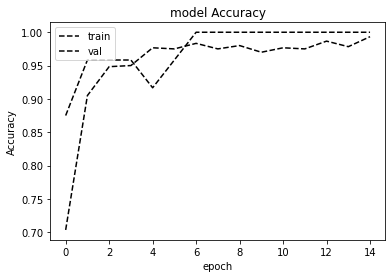

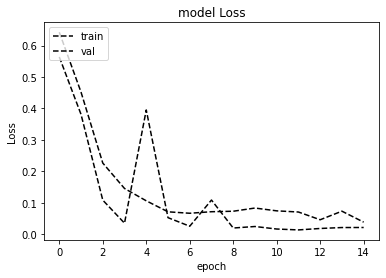

In [0]:
# Plotting Accuracy and Loss curve
plot_curve(hist.history['accuracy'],hist.history['val_accuracy'],'Accuracy')
plot_curve(hist.history['loss'],hist.history['val_loss'],'Loss')

In [0]:

#testing model
step_size_test=test_gen.n//test_gen.batch_size
loss,acc = model1.evaluate_generator(test_gen,step_size_test,verbose=0)
print("Testing Results => Acc: ",round(acc,2)*100,"Loss: ",round(loss,2))

#Plotting ROC curve
print("ROC Curve")
test_gen = get_generator('/content/test',processinput,img_size,batchsize,False)
test_y = test_gen.classes
y_pred = model1.predict_generator(test_gen)
get_ROC(test_y,y_pred)

# Report of Precision, Recall, F1_score
print ('Report : ')
print (classification_report(test_y, np.where(y_pred.flatten()>0.5,1,0) ))

#Confusion matrix
print("DIsplaying Confusion")
labels = [0,1]
cm = confusion_matrix(test_y, np.where(y_pred.flatten()>0.5,1,0), labels)
draw_confusion_matrix(cm,test_y)



# **Xception model**

In [0]:
#Some important variable initializers
batchsize = 8
img_size = (512,448)
myepochs = 100

numbers_list = [1024,512,1]

#Building Xception model
print("Building Xception model")
model1 = get_pretrained_model('xception',freeze = False)
model1 = add_GAP(model1)
model1 = add_dense(model1,numbers_list)

#Declaring neural network
checkpoint_name='xception.h5'
callback1 = mycallbacks(checkpoint_name)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
model1.summary()

#declaring generators
print("Declaring data generators..")
processinput = Xception_processInput
train_gen = get_generator('/content/train',processinput,img_size,batchsize,True)
test_gen = get_generator('/content/test',processinput,img_size,batchsize,True)
val_gen = get_generator('/content/val',processinput,img_size,batchsize,True)

#training the model
hist = start_training(model1,train_gen,val_gen,myepochs,callback1)

Building Xception model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_

In [0]:
# Plotting Accuracy and Loss curve
plot_curve(hist.history['accuracy'],hist.history['val_accuracy'],'Accuracy')
plot_curve(hist.history['loss'],hist.history['val_loss'],'Loss')

In [0]:

#testing model
step_size_test=test_gen.n//test_gen.batch_size
loss,acc = model1.evaluate_generator(test_gen,step_size_test,verbose=0)
print("Testing Results => Acc: ",round(acc,2)*100,"Loss: ",round(loss,2))

#Plotting ROC curve
print("ROC Curve")
test_gen = get_generator('/content/test',processinput,img_size,batchsize,False)
test_y = test_gen.classes
y_pred = model1.predict_generator(test_gen)
get_ROC(test_y,y_pred)

# Report of Precision, Recall, F1_score
print ('Report : ')
print (classification_report(test_y, np.where(y_pred.flatten()>0.5,1,0) ))

#Confusion matrix
print("DIsplaying Confusion")
labels = [0,1]
cm = confusion_matrix(test_y, np.where(y_pred.flatten()>0.5,1,0), labels)
draw_confusion_matrix(cm,test_y)



# **Displaying Wrongly classified images**

In [0]:
model1.load_weights('vgg19.h5')

In [0]:
import cv2
path1 = "/content/test/covid19"
imgfile = os.listdir(path1)
for i in range(len(imgfile)):
  tmppath = os.path.join(path1,imgfile[i])
  img = cv2.imread(tmppath)
  img = cv2.resize(img,(448,448))
  img = np.expand_dims(img,axis=0)
  score = model1.predict(img,steps=1)
  if score > 0.50:
    print("Image index which is wrongly clasified: ",i)

Image no which is wrongly clasified:  15


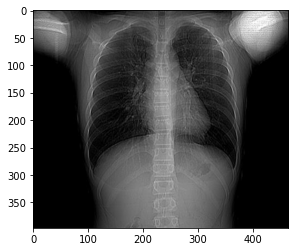

In [0]:
import matplotlib.pyplot as plt
img = cv2.imread(path1+'/'+imgfile[15])
plt.imshow(img)

In [0]:
import cv2
path1 = "/content/test/pneumonia"
imgfile = os.listdir(path1)
for i in range(len(imgfile)):
  tmppath = os.path.join(path1,imgfile[i])
  img = cv2.imread(tmppath)
  img = cv2.resize(img,(448,448))
  img = np.expand_dims(img,axis=0)
  score = model1.predict(img,steps=1)
  if score < 0.50:
    print("Image index which is wrongly clasified: ",i)

Image index which is wrongly clasified:  11


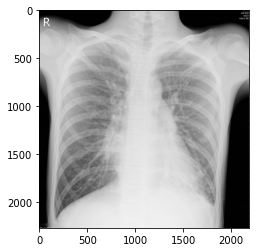

In [0]:
import matplotlib.pyplot as plt
img = cv2.imread(path1+'/'+imgfile[11])
plt.imshow(img)